In [10]:
__author__ = 'Dan Suson <djsuson@fnal.gov>' # single string; emails in <>
__version__ = '20210611' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1','gaia_edr3']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

In [11]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

In [12]:
# getting necessary columns from DELVE within a certain RA and DEC (in this case, -20<dec<-10 and 120<ra<130)
sql_delve =\
'''
SELECT quick_object_id,
spread_model_g,spreaderr_model_g,mag_auto_g,magerr_auto_g,
spread_model_r,spreaderr_model_r,mag_auto_r,magerr_auto_r,
spread_model_i,spreaderr_model_i,mag_auto_i,magerr_auto_i,
spread_model_z,spreaderr_model_z,mag_auto_z,magerr_auto_z
FROM delve_dr1.objects
WHERE dec>-30 and dec<-20 and ra>105 and ra<120
'''
df = qc.query(sql=sql_delve,fmt='pandas')

# getting all objects from patch of sky from -20<dec<-10 and 120<ra<130 from gaia x delve data
sql_gaia =\
'''
SELECT *
FROM gaia_edr3.x1p5__gaia_source__delve_dr1__objects
WHERE dec1>-20 and dec1<-10 and ra1>120 and ra1<135
'''
coords = qc.query(sql=sql_gaia,fmt='pandas')

In [13]:
# turning the DELVE IDs in the gaia dataset into an array
ids = np.array(coords['id2'])

In [14]:
# set indices for reasonable values of spread_model (following plot in fig 6 here: https://arxiv.org/pdf/2103.07476.pdf)
lower_limit = -0.025
upper_limit = 0.045
upper_mag_limit = 26
wide_spread = 0.005
min_spread = 0.003

fraction of objects in gaia catalog for band g:  0.0
fraction of galaxies in gaia catalog for band g:  0.0
fraction of definite galaxies in gaia catalog for band g:  0.0
fraction of objects in gaia catalog for band r:  0.0
fraction of galaxies in gaia catalog for band r:  0.0
fraction of definite galaxies in gaia catalog for band r:  0.0
fraction of objects in gaia catalog for band i:  0.0
fraction of galaxies in gaia catalog for band i:  0.0
fraction of definite galaxies in gaia catalog for band i:  0.0
fraction of objects in gaia catalog for band z:  0.0
fraction of galaxies in gaia catalog for band z:  0.0
fraction of definite galaxies in gaia catalog for band z:  0.0


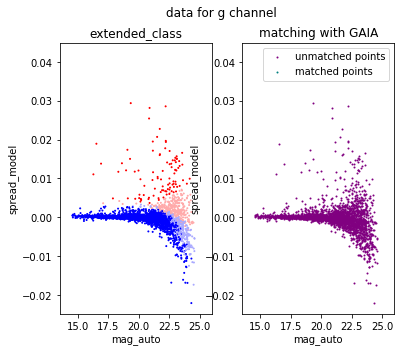

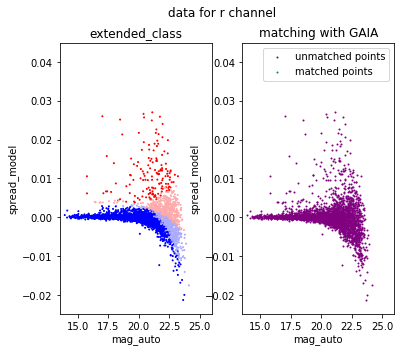

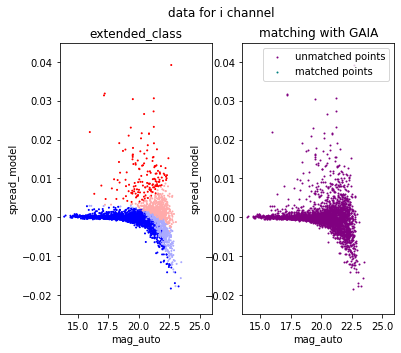

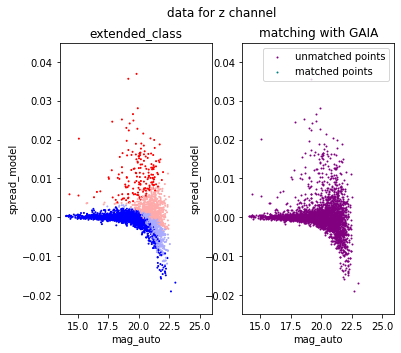

In [15]:
# Loop over single observation bands
bands = ['g', 'r', 'i', 'z']
for band in bands:

  # convert to np arrays
  indices = (df[f'mag_auto_{band}']<upper_mag_limit) & (df[f'spread_model_{band}']<upper_limit) & (df[f'spread_model_{band}']>lower_limit)
  quick_object_id = np.array(df['quick_object_id'][indices])
  mag_auto = np.array(df[f'mag_auto_{band}'][indices])
  spread_model = np.array(df[f'spread_model_{band}'][indices])
  spreaderr_model = np.array(df[f'spreaderr_model_{band}'][indices])
  matches = np.isin(quick_object_id,ids)

  #calculate extended class value
  three_sigma_extension = ((df[f'spread_model_{band}'][indices]).values + 3*(df[f'spreaderr_model_{band}'][indices]).values) > wide_spread
  one_sigma_extension = ((df[f'spread_model_{band}'][indices]).values + (df[f'spreaderr_model_{band}'][indices]).values) > min_spread
  bigger_than_PSF = ((df[f'spread_model_{band}'][indices]).values - (df[f'spreaderr_model_{band}'][indices]).values) > min_spread
   
  extended_class = three_sigma_extension.astype(np.int16) + one_sigma_extension.astype(np.int16) + bigger_than_PSF.astype(np.int16)
  extended_class_match = extended_class[matches]

  # getting the magnitudes/spreads of objects that are matched with gaia
  gaia_mags = df[f'mag_auto_{band}'][indices][matches]
  gaia_spreads = df[f'spread_model_{band}'][indices][matches]
  galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>1])
  galaxy_matches = np.isin(galaxy_ids,ids)
  def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>2])
  def_galaxy_matches = np.isin(def_galaxy_ids,ids)

  # print fractional overlap
  print(f'fraction of objects in gaia catalog for band {band}: ', len(gaia_spreads)/len(spread_model))
  print(f'fraction of galaxies in gaia catalog for band {band}: ', len(galaxy_matches)/len(spread_model))
  print(f'fraction of definite galaxies in gaia catalog for band {band}: ', len(def_galaxy_matches)/len(spread_model))

  # plot stars verses galaxies
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,5))
  fig.suptitle(f'data for {band} channel')
  ax1.scatter(mag_auto[::100], spread_model[::100], c=extended_class[::100], cmap='bwr', vmin=0, vmax=3, s=1)
  ax1.set_xlabel('mag_auto')
  ax1.set_ylabel('spread_model')
  ax1.set_title(f'extended_class')
  ax1.set_xlim([13.5,26])
  ax1.set_ylim([-0.025,0.045])

  # plott the matches with GAIA
  ax2.scatter(mag_auto[::100], spread_model[::100], c='purple', s=1, label='unmatched points')
  ax2.scatter(gaia_mags[::100], gaia_spreads[::100], c='teal', s=1, label='matched points')
  ax2.set_xlabel('mag_auto')
  ax2.set_ylabel('spread_model')
  ax2.set_title(f'matching with GAIA')
  ax2.set_xlim([13.5,26])
  ax2.set_ylim([-0.025,0.045])
  ax2.legend(loc='best')

fraction of objects in gaia catalog for band gr:  0.0
fraction of galaxies in gaia catalog for band gr:  0.0
fraction of galaxies in gaia catalog for band gr using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band gr:  0.0
fraction of definite galaxies in gaia catalog for band gr using weighted average:  0.0
fraction of objects in gaia catalog for band gi:  0.0
fraction of galaxies in gaia catalog for band gi:  0.0
fraction of galaxies in gaia catalog for band gi using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band gi:  0.0
fraction of definite galaxies in gaia catalog for band gi using weighted average:  0.0
fraction of objects in gaia catalog for band gz:  0.0
fraction of galaxies in gaia catalog for band gz:  0.0
fraction of galaxies in gaia catalog for band gz using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band gz:  0.0
fraction of definite galaxies in gaia catalog for band gz using weighted 

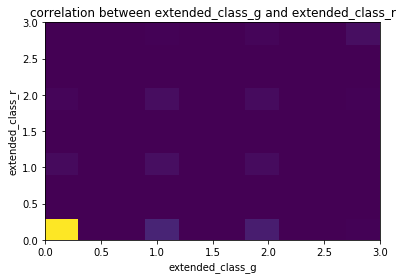

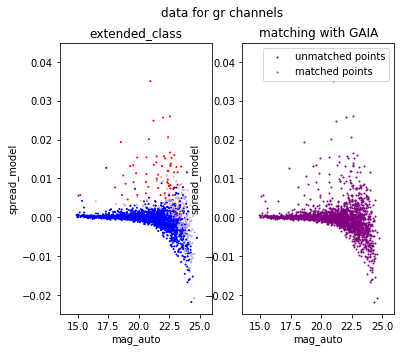

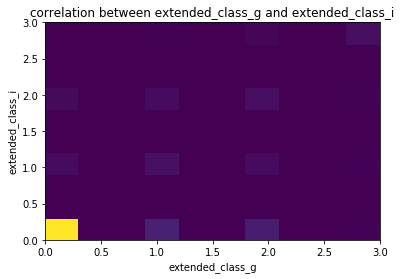

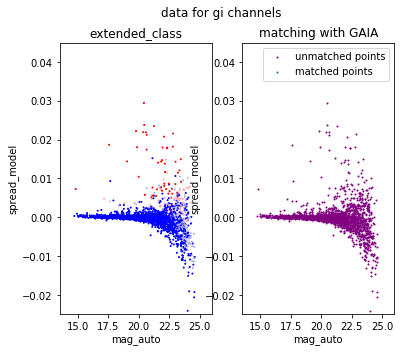

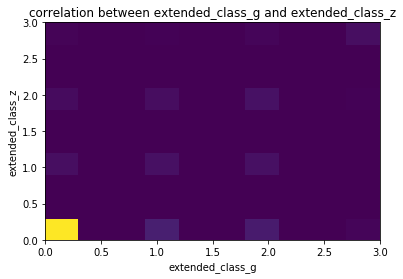

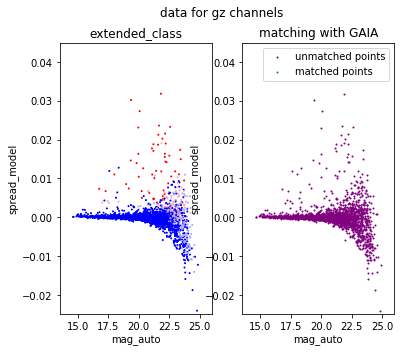

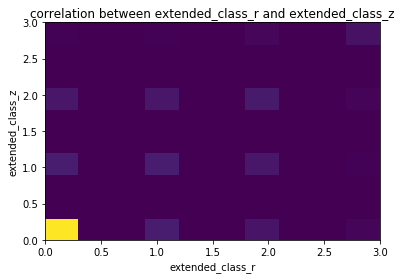

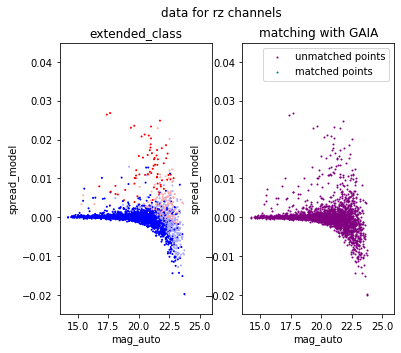

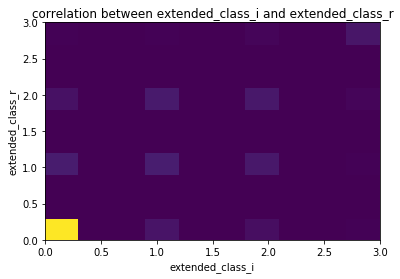

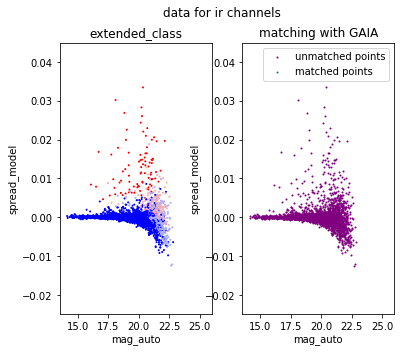

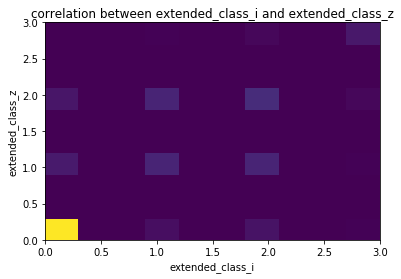

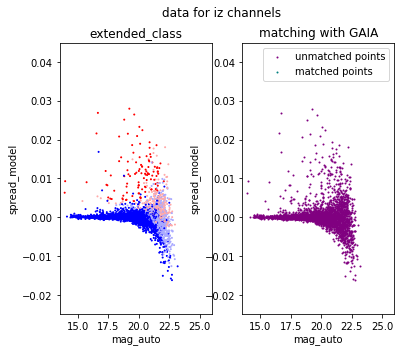

In [16]:
# Loop over two observation bands combined
for band1 in bands:
  for band2 in bands:
    if band2 > band1:

      # convert to np arrays
      indices = (df[f'mag_auto_{band1}']<upper_mag_limit) & (df[f'spread_model_{band1}']<upper_limit) & (df[f'spread_model_{band1}']>lower_limit) \
      & (df[f'mag_auto_{band2}']<upper_mag_limit) & (df[f'spread_model_{band2}']<upper_limit) & (df[f'spread_model_{band2}']>lower_limit)
      quick_object_id = np.array(df['quick_object_id'][indices])
      mag_auto = np.array(df[f'mag_auto_{band1}'][indices])
      spread_model = np.array(df[f'spread_model_{band1}'][indices])
      spreaderr_model = np.array(df[f'spreaderr_model_{band1}'][indices])
      matches = np.isin(quick_object_id,ids)

      #calculate extended class value
      three_sigma_extension_band1 = ((df[f'spread_model_{band1}'][indices]).values + 3*(df[f'spreaderr_model_{band1}'][indices]).values) > wide_spread
      one_sigma_extension_band1 = ((df[f'spread_model_{band1}'][indices]).values + (df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
      bigger_than_PSF_band1 = ((df[f'spread_model_{band1}'][indices]).values - (df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
      weight1 = 1 / (df[f'magerr_auto_{band1}'][indices])**2
      three_sigma_extension_band2 = ((df[f'spread_model_{band2}'][indices]).values + 3*(df[f'spreaderr_model_{band2}'][indices]).values) > wide_spread
      one_sigma_extension_band2 = ((df[f'spread_model_{band2}'][indices]).values + (df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
      bigger_than_PSF_band2 = ((df[f'spread_model_{band2}'][indices]).values - (df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
      weight2 = 1 / (df[f'magerr_auto_{band2}'][indices])**2
   
      extended_class_band1 = three_sigma_extension_band1.astype(np.int16) + one_sigma_extension_band1.astype(np.int16) + bigger_than_PSF_band1.astype(np.int16)
      extended_class_band2 = three_sigma_extension_band2.astype(np.int16) + one_sigma_extension_band2.astype(np.int16) + bigger_than_PSF_band2.astype(np.int16)
      extended_class_all = np.array([extended_class_band1,extended_class_band2])
      extended_class = np.min(extended_class_all,axis=0)
      extended_class_match = extended_class[matches]
      weight_sum = weight1 + weight2
      ave_extended_class = (extended_class_band1*weight1 + extended_class_band2*weight2) / weight_sum
      ave_class_match = ave_extended_class[matches]
    
      fig, ax = plt.subplots(1,1)
      ax.hist2d(extended_class_band1[::100],extended_class_band2[::100])
      ax.set_xlabel(f'extended_class_{band1}')
      ax.set_ylabel(f'extended_class_{band2}')
      ax.set_title(f'correlation between extended_class_{band1} and extended_class_{band2}')
      
      # getting the magnitudes/spreads of objects that are matched with gaia
      gaia_mags = df[f'mag_auto_{band1}'][indices][matches]
      gaia_spreads = df[f'spread_model_{band1}'][indices][matches]
      galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>1])
      galaxy_matches = np.isin(galaxy_ids,ids)
      ave_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>1])
      ave_galaxy_matches = np.isin(ave_galaxy_ids,ids)
      def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>2])
      def_galaxy_matches = np.isin(def_galaxy_ids,ids)
      ave_def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>2])
      ave_def_galaxy_matches = np.isin(ave_def_galaxy_ids,ids)

      # print fractional overlap
      print(f'fraction of objects in gaia catalog for band {band1}{band2}: ', len(gaia_spreads)/len(spread_model))
      print(f'fraction of galaxies in gaia catalog for band {band1}{band2}: ', len(galaxy_matches)/len(spread_model))
      print(f'fraction of galaxies in gaia catalog for band {band1}{band2} using weighted average: ', len(ave_galaxy_matches)/len(spread_model))
      print(f'fraction of definite galaxies in gaia catalog for band {band1}{band2}: ', len(def_galaxy_matches)/len(spread_model))
      print(f'fraction of definite galaxies in gaia catalog for band {band1}{band2} using weighted average: ', len(ave_def_galaxy_matches)/len(spread_model))

      # plot stars verses galaxies
      fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,5))
      fig.suptitle(f'data for {band1}{band2} channels')
      ax1.scatter(mag_auto[::100], spread_model[::100], c=extended_class[::100], cmap='bwr', vmin=0, vmax=3, s=1)
      ax1.set_xlabel('mag_auto')
      ax1.set_ylabel('spread_model')
      ax1.set_title(f'extended_class')
      ax1.set_xlim([13.5,26])
      ax1.set_ylim([-0.025,0.045])

      # plott the matches with GAIA
      ax2.scatter(mag_auto[::100], spread_model[::100], c='purple', s=1, label='unmatched points')
      ax2.scatter(gaia_mags[::100], gaia_spreads[::100], c='teal', s=1, label='matched points')
      ax2.set_xlabel('mag_auto')
      ax2.set_ylabel('spread_model')
      ax2.set_title(f'matching with GAIA')
      ax2.set_xlim([13.5,26])
      ax2.set_ylim([-0.025,0.045])
      ax2.legend(loc='best')

fraction of objects in gaia catalog for band grz:  0.0
fraction of galaxies in gaia catalog for band grz:  0.0
fraction of galaxies in gaia catalog for band grz using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band grz:  0.0
fraction of definite galaxies in gaia catalog for band grz using weighted average:  0.0
fraction of objects in gaia catalog for band gir:  0.0
fraction of galaxies in gaia catalog for band gir:  0.0
fraction of galaxies in gaia catalog for band gir using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band gir:  0.0
fraction of definite galaxies in gaia catalog for band gir using weighted average:  0.0
fraction of objects in gaia catalog for band giz:  0.0
fraction of galaxies in gaia catalog for band giz:  0.0
fraction of galaxies in gaia catalog for band giz using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band giz:  0.0
fraction of definite galaxies in gaia catalog for band giz 

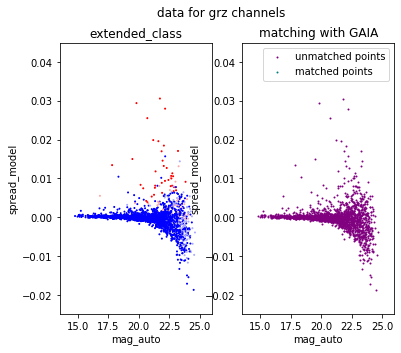

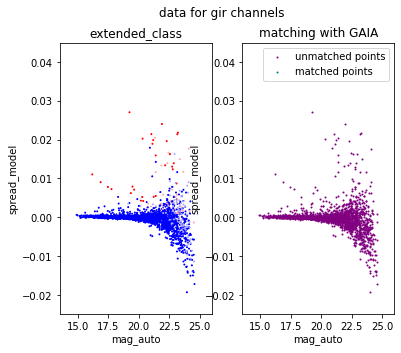

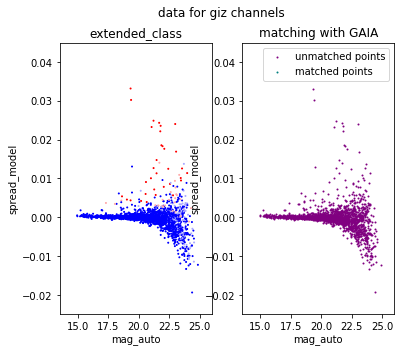

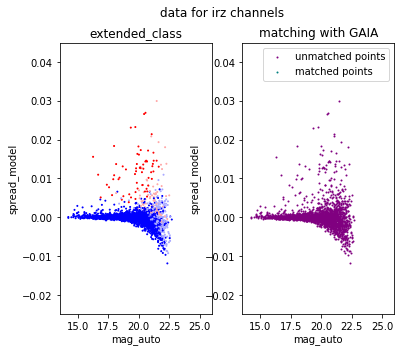

In [17]:
# Loop over three observation bands combined
for band1 in bands:
  for band2 in bands:
    for band3 in bands:
      if band2 > band1:
        if band3 > band2:

          # convert to np arrays
          indices = (df[f'mag_auto_{band1}']<upper_mag_limit) & (df[f'spread_model_{band1}']<upper_limit) & (df[f'spread_model_{band1}']>lower_limit) \
          & (df[f'mag_auto_{band2}']<upper_mag_limit) & (df[f'spread_model_{band2}']<upper_limit) & (df[f'spread_model_{band2}']>lower_limit) \
          & (df[f'mag_auto_{band3}']<upper_mag_limit) & (df[f'spread_model_{band3}']<upper_limit) & (df[f'spread_model_{band3}']>lower_limit)
          quick_object_id = np.array(df['quick_object_id'][indices])
          mag_auto = np.array(df[f'mag_auto_{band1}'][indices])
          spread_model = np.array(df[f'spread_model_{band1}'][indices])
          spreaderr_model = np.array(df[f'spreaderr_model_{band1}'][indices])
          matches = np.isin(quick_object_id,ids)

          #calculate extended class value
          three_sigma_extension_band1 = ((df[f'spread_model_{band1}'][indices]).values + 3*(df[f'spreaderr_model_{band1}'][indices]).values) > wide_spread
          one_sigma_extension_band1 = ((df[f'spread_model_{band1}'][indices]).values + (df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
          bigger_than_PSF_band1 = ((df[f'spread_model_{band1}'][indices]).values - (df[f'spreaderr_model_{band1}'][indices]).values) > min_spread
          weight1 = 1 / (df[f'magerr_auto_{band1}'][indices])**2
          three_sigma_extension_band2 = ((df[f'spread_model_{band2}'][indices]).values + 3*(df[f'spreaderr_model_{band2}'][indices]).values) > wide_spread
          one_sigma_extension_band2 = ((df[f'spread_model_{band2}'][indices]).values + (df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
          bigger_than_PSF_band2 = ((df[f'spread_model_{band2}'][indices]).values - (df[f'spreaderr_model_{band2}'][indices]).values) > min_spread
          weight2 = 1 / (df[f'magerr_auto_{band2}'][indices])**2
          three_sigma_extension_band3 = ((df[f'spread_model_{band3}'][indices]).values + 3*(df[f'spreaderr_model_{band3}'][indices]).values) > wide_spread
          one_sigma_extension_band3 = ((df[f'spread_model_{band3}'][indices]).values + (df[f'spreaderr_model_{band3}'][indices]).values) > min_spread
          bigger_than_PSF_band3 = ((df[f'spread_model_{band3}'][indices]).values - (df[f'spreaderr_model_{band3}'][indices]).values) > min_spread
          weight3 = 1 / (df[f'magerr_auto_{band3}'][indices])**2
  
          extended_class_band1 = three_sigma_extension_band1.astype(np.int16) + one_sigma_extension_band1.astype(np.int16) + bigger_than_PSF_band1.astype(np.int16)
          extended_class_band2 = three_sigma_extension_band2.astype(np.int16) + one_sigma_extension_band2.astype(np.int16) + bigger_than_PSF_band2.astype(np.int16)
          extended_class_band3 = three_sigma_extension_band3.astype(np.int16) + one_sigma_extension_band3.astype(np.int16) + bigger_than_PSF_band3.astype(np.int16)
          extended_class_all = np.array([extended_class_band1, extended_class_band2, extended_class_band3])
          extended_class = np.min(extended_class_all,axis=0)
          extended_class_match = extended_class[matches]
          weight_sum = weight1 + weight2 + weight3
          ave_extended_class = (extended_class_band1*weight1 + extended_class_band2*weight2 + extended_class_band3*weight3) / weight_sum
          ave_class_match = ave_extended_class[matches]

          # getting the magnitudes/spreads of objects that are matched with gaia
          gaia_mags = df[f'mag_auto_{band1}'][indices][matches]
          gaia_spreads = df[f'spread_model_{band1}'][indices][matches]
          galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>1])
          galaxy_matches = np.isin(galaxy_ids,ids)
          ave_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>1])
          ave_galaxy_matches = np.isin(ave_galaxy_ids,ids)
          def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>2])
          def_galaxy_matches = np.isin(def_galaxy_ids,ids)
          ave_def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>2])
          ave_def_galaxy_matches = np.isin(ave_def_galaxy_ids,ids)

          # print fractional overlap
          print(f'fraction of objects in gaia catalog for band {band1}{band2}{band3}: ', len(gaia_spreads)/len(spread_model))
          print(f'fraction of galaxies in gaia catalog for band {band1}{band2}{band3}: ', len(galaxy_matches)/len(spread_model))
          print(f'fraction of galaxies in gaia catalog for band {band1}{band2}{band3} using weighted average: ', len(ave_galaxy_matches)/len(spread_model))
          print(f'fraction of definite galaxies in gaia catalog for band {band1}{band2}{band3}: ', len(def_galaxy_matches)/len(spread_model))
          print(f'fraction of definite galaxies in gaia catalog for band {band1}{band2}{band3} using weighted average: ', len(ave_def_galaxy_matches)/len(spread_model))

          # plot stars verses galaxies
          fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,5))
          fig.suptitle(f'data for {band1}{band2}{band3} channels')
          ax1.scatter(mag_auto[::100], spread_model[::100], c=extended_class[::100], cmap='bwr', vmin=0, vmax=3, s=1)
          ax1.set_xlabel('mag_auto')
          ax1.set_ylabel('spread_model')
          ax1.set_title(f'extended_class')
          ax1.set_xlim([13.5,26])
          ax1.set_ylim([-0.025,0.045])

          # plott the matches with GAIA
          ax2.scatter(mag_auto[::100], spread_model[::100], c='purple', s=1, label='unmatched points')
          ax2.scatter(gaia_mags[::100], gaia_spreads[::100], c='teal', s=1, label='matched points')
          ax2.set_xlabel('mag_auto')
          ax2.set_ylabel('spread_model')
          ax2.set_title(f'matching with GAIA')
          ax2.set_xlim([13.5,26])
          ax2.set_ylim([-0.025,0.045])
          ax2.legend(loc='best')

fraction of objects in gaia catalog for band griz:  0.0
fraction of galaxies in gaia catalog for band griz:  0.0
fraction of galaxies in gaia catalog for band griz using weighted average:  0.0
fraction of definite galaxies in gaia catalog for band griz:  0.018448150368213734
fraction of definite galaxies in gaia catalog for band griz using weighted average:  0.0


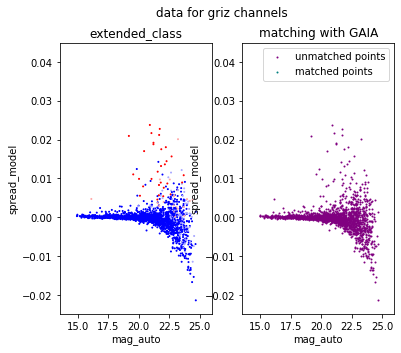

In [18]:
# Look at all four bands combined

# convert to np arrays
indices = (df[f'mag_auto_g']<upper_mag_limit) & (df[f'spread_model_g']<upper_limit) & (df[f'spread_model_g']>lower_limit) \
& (df[f'mag_auto_r']<upper_mag_limit) & (df[f'spread_model_r']<upper_limit) & (df[f'spread_model_r']>lower_limit) \
& (df[f'mag_auto_i']<upper_mag_limit) & (df[f'spread_model_i']<upper_limit) & (df[f'spread_model_i']>lower_limit) \
& (df[f'mag_auto_z']<upper_mag_limit) & (df[f'spread_model_z']<upper_limit) & (df[f'spread_model_z']>lower_limit)
quick_object_id = np.array(df['quick_object_id'][indices])
mag_auto = np.array(df[f'mag_auto_g'][indices])
spread_model = np.array(df[f'spread_model_g'][indices])
spreaderr_model = np.array(df[f'spreaderr_model_g'][indices])
matches = np.isin(quick_object_id,ids)

#calculate extended class value
three_sigma_extension_g = ((df[f'spread_model_g'][indices]).values + 3*(df[f'spreaderr_model_g'][indices]).values) > wide_spread
one_sigma_extension_g = ((df[f'spread_model_g'][indices]).values + (df[f'spreaderr_model_g'][indices]).values) > min_spread
bigger_than_PSF_g = ((df[f'spread_model_g'][indices]).values - (df[f'spreaderr_model_g'][indices]).values) > min_spread
weightg = 1 / (df[f'magerr_auto_g'][indices])**2
three_sigma_extension_r = ((df[f'spread_model_r'][indices]).values + 3*(df[f'spreaderr_model_r'][indices]).values) > wide_spread
one_sigma_extension_r = ((df[f'spread_model_r'][indices]).values + (df[f'spreaderr_model_r'][indices]).values) > min_spread
bigger_than_PSF_r = ((df[f'spread_model_r'][indices]).values - (df[f'spreaderr_model_r'][indices]).values) > min_spread
weightr = 1 / (df[f'magerr_auto_r'][indices])**2
three_sigma_extension_i = ((df[f'spread_model_i'][indices]).values + 3*(df[f'spreaderr_model_i'][indices]).values) > wide_spread
one_sigma_extension_i = ((df[f'spread_model_i'][indices]).values + (df[f'spreaderr_model_i'][indices]).values) > min_spread
bigger_than_PSF_i = ((df[f'spread_model_i'][indices]).values - (df[f'spreaderr_model_i'][indices]).values) > min_spread
weighti = 1 / (df[f'magerr_auto_i'][indices])**2
three_sigma_extension_z = ((df[f'spread_model_z'][indices]).values + 3*(df[f'spreaderr_model_z'][indices]).values) > wide_spread
one_sigma_extension_z = ((df[f'spread_model_z'][indices]).values + (df[f'spreaderr_model_z'][indices]).values) > min_spread
bigger_than_PSF_z = ((df[f'spread_model_z'][indices]).values - (df[f'spreaderr_model_z'][indices]).values) > min_spread
weightz = 1 / (df[f'magerr_auto_z'][indices])**2
   
extended_class_g = three_sigma_extension_g.astype(np.int16) + one_sigma_extension_g.astype(np.int16) + bigger_than_PSF_g.astype(np.int16)
extended_class_r = three_sigma_extension_r.astype(np.int16) + one_sigma_extension_r.astype(np.int16) + bigger_than_PSF_r.astype(np.int16)
extended_class_i = three_sigma_extension_i.astype(np.int16) + one_sigma_extension_i.astype(np.int16) + bigger_than_PSF_i.astype(np.int16)
extended_class_z = three_sigma_extension_z.astype(np.int16) + one_sigma_extension_z.astype(np.int16) + bigger_than_PSF_z.astype(np.int16)
extended_class_all = np.array([extended_class_g, extended_class_r, extended_class_i, extended_class_z])
extended_class = np.min(extended_class_all,axis=0)
extended_class_match = extended_class[matches]
weight_sum = weightg + weightr + weighti + weightz
ave_extended_class = (extended_class_g*weightg + extended_class_r*weightr + extended_class_i*weighti + extended_class_z*weightz) / weight_sum
ave_class_match = ave_extended_class[matches]

# getting the magnitudes/spreads of objects that are matched with gaia
gaia_mags = df[f'mag_auto_g'][indices][matches]
gaia_spreads = df[f'spread_model_g'][indices][matches]
galaxy_ids = np.array(df['quick_object_id'][indices][matches][extended_class_match>1])
galaxy_matches = np.isin(galaxy_ids,ids)
ave_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>1])
ave_galaxy_matches = np.isin(ave_galaxy_ids,ids)
def_galaxy_ids = np.array(df['quick_object_id'][indices][extended_class>2])
def_galaxy_matches = np.isin(def_galaxy_ids,ids)
ave_def_galaxy_ids = np.array(df['quick_object_id'][indices][matches][ave_class_match>2])
ave_def_galaxy_matches = np.isin(ave_def_galaxy_ids,ids)

# print fractional overlap
print(f'fraction of objects in gaia catalog for band griz: ', len(gaia_spreads)/len(spread_model))
print(f'fraction of galaxies in gaia catalog for band griz: ', len(galaxy_matches)/len(spread_model))
print(f'fraction of galaxies in gaia catalog for band griz using weighted average: ', len(ave_galaxy_matches)/len(spread_model))
print(f'fraction of definite galaxies in gaia catalog for band griz: ', len(def_galaxy_matches)/len(spread_model))
print(f'fraction of definite galaxies in gaia catalog for band griz using weighted average: ', len(ave_def_galaxy_matches)/len(spread_model))

# plot stars verses galaxies
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,5))
fig.suptitle(f'data for griz channels')
ax1.scatter(mag_auto[::100], spread_model[::100], c=extended_class[::100], cmap='bwr', vmin=0, vmax=3, s=1)
ax1.set_xlabel('mag_auto')
ax1.set_ylabel('spread_model')
ax1.set_title(f'extended_class')
ax1.set_xlim([13.5,26])
ax1.set_ylim([-0.025,0.045])

# plott the matches with GAIA
ax2.scatter(mag_auto[::100], spread_model[::100], c='purple', s=1, label='unmatched points')
ax2.scatter(gaia_mags[::100], gaia_spreads[::100], c='teal', s=1, label='matched points')
ax2.set_xlabel('mag_auto')
ax2.set_ylabel('spread_model')
ax2.set_title(f'matching with GAIA')
ax2.set_xlim([13.5,26])
ax2.set_ylim([-0.025,0.045])
ax2.legend(loc='best')